In [1]:
# 全局攻击 数据集：异配图数据集；代理模型：H2GCN；攻击算法：最新的代码
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torch_geometric.transforms as T
import torch.optim as optim
import scipy.sparse as sp
from copy import deepcopy
from torch_geometric.utils import to_undirected
from torch_sparse import SparseTensor
import matplotlib.pyplot as plt
import time

from utils import *
from H2GCN import H2GCN
from gcn import GCN

Using backend: pytorch


In [2]:
# 模拟命令行参数
class Args:
    def __init__(self, dataset='cora'):
        self.seed = 15
        self.dataset = dataset
        self.input_size = 0
        self.output_size = 0
        self.hidden_size = 64
        self.epochs = 2000
        self.lr = 0.001
        self.drop_prob = 0.5
        self.round = 2
        self.train_ratio = 0.6
        self.patience = 200

# 传入特定的参数值
args = Args(dataset='texas') 
# 默认dataset为'cora'，可以传入的dataset参数有：choices=['cora', 'citeseer', 'pubmed', 'film', 'squirrel', 'chameleon', 'texas', 'cornell', 'wisconsin']

In [3]:
# 是否使用cuda
args.cuda = torch.cuda.is_available()
print('cuda: %s' % args.cuda)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

np.random.seed(args.seed)
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

cuda: True


In [4]:
"""
# 加载数据集
g, nclass, features, labels, train, val, test = preprocess_data(args.dataset, args.train_ratio)

features = features.to(device)
labels = labels.to(device)

idx_train = train.numpy()
idx_test = test.numpy()
idx_val = val.numpy()

train = train.to(device)
test = test.to(device)
val = val.to(device)
"""

'\n# 加载数据集\ng, nclass, features, labels, train, val, test = preprocess_data(args.dataset, args.train_ratio)\n\nfeatures = features.to(device)\nlabels = labels.to(device)\n\nidx_train = train.numpy()\nidx_test = test.numpy()\nidx_val = val.numpy()\n\ntrain = train.to(device)\ntest = test.to(device)\nval = val.to(device)\n'

In [5]:
# 加载数据集
g, nclass, features, labels, train, val, test = preprocess_data(args.dataset, args.train_ratio)

features = features.to(device)
labels = labels.to(device)

n = len(labels)
train = torch.arange(0, int(0.1 * n))
val = torch.arange(int(0.1 * n), int(0.2 * n))
test = torch.arange(int(0.2 * n), n)

idx_train = train.numpy()
idx_val = val.numpy()
idx_test = test.numpy()

train = train.to(device)
test = test.to(device)
val = val.to(device)

/home/wangyajing/anaconda3/envs/DeepRobust/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


texas 5


In [6]:
node_classes=labels
# 使用torch.unique函数获取唯一值
unique_classes = torch.unique(node_classes)
# 获取唯一值的数量
c = len(unique_classes)
num_loops = 2
perturbed_rate = 0.9 # 扰动率
print("一共有 {} 个类别。".format(c))

一共有 5 个类别。


In [7]:
# 得到adj和adj_2hop
def toCSR(spt):
    rowptr, col, value = spt.csr()
    mat = sp.csr_matrix((value, col, rowptr)).tolil()
    mat.setdiag(0)
    return mat.tocsr()

edge_index = to_undirected(g.edges())
adj = SparseTensor(row=edge_index[0], col=edge_index[1],
                   sparse_sizes=(g.num_nodes(), g.num_nodes())).fill_value(1.0)
adj2 = adj.matmul(adj).fill_value(1.0)
adj_2hop = (toCSR(adj2) - toCSR(adj)) > 0
adj_2hop = SparseTensor.from_scipy(adj_2hop).fill_value(1.0)

adj = adj.to(device)
adj_clean = adj
adj_2hop = adj_2hop.to(device)

In [8]:
# 得到目标节点的一跳和两跳邻居节点
# target_nodes = np.random.randint(15, labels.numel(), size=20)
dense_adj = adj.to_dense().cpu().numpy()
dense_adj_2hop = adj_2hop.to_dense().cpu().numpy()

In [9]:
def train_model(model, adj, adj_2hop, optimizer, loss_fn):
    model.train()
    logits = model(features, adj, adj_2hop)
    pred = logits.argmax(dim=-1)
    train_loss = loss_fn(logits[train], labels[train])
    train_acc = (pred[train] == labels[train]).float().mean()
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    return train_loss, train_acc

def evaluate_val(model, adj, adj_2hop):
    model.eval()
    with torch.no_grad():
        logits = model(features, adj, adj_2hop)

    pred = logits.argmax(dim=-1)
    val_acc = (pred[val] == labels[val]).float().mean()
    return val_acc

def evaluate_test(model, adj, adj_2hop):
    model.eval()
    with torch.no_grad():
        logits = model(features, adj, adj_2hop)
    pred = logits.argmax(dim=-1)
    test_acc = (pred[test] == labels[test]).float().mean()
    
    """
    info = 0
    for i in range(c):
        id_lables = test[np.where(labels[test].to('cpu') == i)] # 标签为0的节点id
        count = 0
        sum_count = len(pred[id_lables])
        for j in range(sum_count):
             if(pred[id_lables][j] == labels[id_lables][j]):
                 count +=1
        p = count/sum_count
        
    info += (-p) * np.log(p)
    print(info)
    """
    
    return test_acc

In [10]:
# H2GCN模型初始化
# 使用torch.unique()函数找到张量中的唯一值
unique_classes = torch.unique(labels)
# 统计唯一值的数量，即类别数
num_classes = len(unique_classes)
# 模型参数设置
args.input_size = len(features[0])
args.output_size = num_classes

model = H2GCN(in_channels=args.input_size,
                hidden_channels=args.hidden_size,
                out_channels=args.output_size,
                drop_prob=args.drop_prob,
                round=args.round)

model = model.to(device)

# 训练模型
optimizer = optim.Adam(params=model.parameters(), lr=args.lr)
loss_fn = nn.NLLLoss()

best_val_acc, best_model = 0., None
for i in range(args.epochs):
    train_loss, train_acc = train_model(model, adj, adj_2hop, optimizer, loss_fn)
    val_acc = evaluate_val(model, adj, adj_2hop)
    if (i + 1) % 200 == 0:
        print("ep{}: train loss: {:.4f} train acc: {:.4f} val acc: {:.4f}".format(i + 1, train_loss, train_acc, val_acc))

    if best_val_acc < val_acc:
        best_val_acc = val_acc
        best_model = deepcopy(model)

test_acc = evaluate_test(best_model, adj, adj_2hop)
print("test acc: {:.4f}".format(test_acc))

ep200: train loss: 0.8018 train acc: 0.6667 val acc: 0.5556
ep400: train loss: 0.6211 train acc: 0.8333 val acc: 0.6111
ep600: train loss: 0.8201 train acc: 0.7222 val acc: 0.6111
ep800: train loss: 0.5312 train acc: 0.7778 val acc: 0.6111
ep1000: train loss: 0.3200 train acc: 0.9444 val acc: 0.5000
ep1200: train loss: 0.2339 train acc: 0.9444 val acc: 0.5556
ep1400: train loss: 0.1569 train acc: 0.9444 val acc: 0.5000
ep1600: train loss: 0.1788 train acc: 0.9444 val acc: 0.5000
ep1800: train loss: 0.1427 train acc: 0.9444 val acc: 0.4444
ep2000: train loss: 0.0951 train acc: 0.9444 val acc: 0.5000
test acc: 0.6190


In [11]:
# 预算，修改的边的数量
budget = int(g.num_edges() * perturbed_rate)

# 全部节点的度
d = torch.sum(adj[test].to_dense(), dim = 1)
d = d.int()

# 全部节点的二阶邻域的度
d2 = torch.sum(adj_2hop[test].to_dense(), dim = 1)
d2 = d2.int()

# 转换为 CSR matrix，得到被攻击的初始图（=原图）
adj_attacked = g.adjacency_matrix(transpose=True, scipy_fmt="csr")
adj_attacked = adj_attacked.astype(np.float32)

# 假设你想要添加的边的权重是1
edge_weight = 1

In [12]:
start_time = time.time()  # 获取开始时间

In [13]:
def attack(dense_adj, dense_adj_2hop, d_dim): # d_dim表示几阶邻域度
    global budget
    # 筛选：得到modi_node_idx、modi_node_label、edges_to_connect，分别表示修改的节点ID、修改的节点的标签、修改的节点需要添加的连接数
    modi_node_idx1 = []
    modi_node_label1 = []
    edges_to_connect1 = []
    modi_node_idx2 = []
    modi_node_label2 = []
    edges_to_connect2 = []
    sam1hop_sum = 0
    sam2hop_sum = 0
    for i in range(len(test)):
        target_node = test[i]
        target_label = labels[target_node]
        indices_adj = np.where(dense_adj[target_node] == 1)
        indices_adj_2hop = np.where(dense_adj_2hop[target_node] == 1)
        neighbor_labels = labels[indices_adj]
        neighbor_2hop__labels = labels[indices_adj_2hop]
        count1 = torch.sum(torch.eq(neighbor_labels, target_label))
        total_elements1 = neighbor_labels.numel()
        count2 = torch.sum(torch.eq(neighbor_2hop__labels, target_label))
        total_elements2 = neighbor_2hop__labels.numel()
        sam1hop = count1/total_elements1
        sam2hop = count2/total_elements2    
        sam1hop_sum += abs(sam1hop - 1/c)
        sam2hop_sum += abs(sam2hop - 1/c)
        if d_dim==1: # 如果是一阶邻域的度
            if count1!=0 and d[i]>2: # 度大于2并且节点周围有与该节点标签一样的一阶邻居
                modi_node_idx1.append(target_node.item())
                modi_node_label1.append(labels[target_node].item())
                edges_to_connect1.append(int(c * count1 -d[i].item()))
            if count1==0 and d[i]>2: # 度大于2并且节点周围没有与该节点标签一样的一阶邻居
                modi_node_idx2.append(target_node.item())
                modi_node_label2.append(labels[target_node].item())
                edges_to_connect2.append(d[i].item())
        elif d_dim==2: # 如果是二阶邻域的度
            if count2!=0 and d2[i]>2: # 度大于2并且节点周围有与该节点标签一样的二阶邻居
                #print("邻居：", indices_adj[0][0])
                neighbor_id = indices_adj[0][0]
                #modi_node_idx1.append(target_node.item())
                #modi_node_label1.append(labels[target_node].item())
                modi_node_idx1.append(neighbor_id)
                modi_node_label1.append(labels[neighbor_id].item())
                edges_to_connect1.append(int(c * count2 -d2[i].item()))
            if count2==0 and d2[i]>2: # 度大于2并且节点周围没有与该节点标签一样的二阶邻居
                #print("邻居：", indices_adj[0][0])
                neighbor_id = indices_adj[0][0]
                #modi_node_idx2.append(target_node.item())
                #modi_node_label2.append(labels[target_node].item())
                modi_node_idx2.append(neighbor_id)
                modi_node_label2.append(labels[neighbor_id].item())
                edges_to_connect2.append(d2[i].item())

    # 排序：先攻击connect_num大的节点（实验结果）
    connect_num = [[] for _ in range(c)]
    sorted_num = [[] for _ in range(c)]
    idxs = [[] for _ in range(c)]
    for i in range(c):
        for j in range(len(modi_node_idx1)):
            if(modi_node_label1[j] == i):
                connect_num[i].append(edges_to_connect1[j])
                idxs[i].append(modi_node_idx1[j])
                sorted_num[i].append(edges_to_connect1[j]) # 先攻击connect_num大的节点
        # 建立索引列表并根据 a[j] 的值排序（从大到小）
        sorted_indices = sorted(range(len(sorted_num[i])), key=lambda x: sorted_num[i][x], reverse=True)
        # 根据排序后的索引重新排列 b[j]
        sorted_idxs = [idxs[i][k] for k in sorted_indices]
        # 根据排序后的索引重新排列 a[j]
        sorted_edges_to_connect = [connect_num[i][k] for k in sorted_indices]
        # 更新 a[j] 和 b[j]
        connect_num[i] = sorted_edges_to_connect
        idxs[i] = sorted_idxs

    num = 0
    # 攻击不完全异配的节点
    for i in range(c):
        for k in range(len(connect_num[i])):
            for j in range(c):
                for q in range(len(connect_num[j])):
                    if(budget>0 and i!=j and connect_num[i][k]>0 and connect_num[j][q]>0):
                        a = idxs[i][k]
                        b = idxs[j][q]
                        if adj_attacked[a,b] == 0: # 如果节点i和节点j不同类且未连接在一起
                            adj_attacked[a,b] = edge_weight # 连接节点i和节点j
                            connect_num[i][k] -= 1 # 节点i要连接的边数减去1
                            connect_num[j][q] -= 1 # 节点j要连接的边数减去1
                            budget -= 1 # 预算减去1
                            num = num + 1 #添加的边数

                           
    # 攻击完全异配的节点
    for i in range(len(modi_node_idx2)):  # 42个目标节点，下标0-41
        for j in range(len(modi_node_idx2)):
            if edges_to_connect2[i] > 0 and budget>0: # 如果节点i要连接的边数大于0
                if modi_node_label2[i] == modi_node_label2[j] and adj_attacked[i,j] == 0: # 如果节点i和节点j同类且未连接在一起
                    adj_attacked[i,j] = edge_weight # 连接节点i和节点j
                    edges_to_connect2[i] -= 1 # 节点i要连接的边数减去1
                    edges_to_connect2[j] -= 1 # 节点j要连接的边数减去1
                    budget -= 1 # 预算减去1
                    num = num + 1 #添加的边数
    
     
    print(num)
    
    return num

In [14]:
def trans1(features):
    # 转features数据格式
    # 获取非零元素的索引和对应的值
    indices = torch.nonzero(features).t()
    values = features[indices[0], indices[1]]
    # 构建CSR格式的三个数组
    row_ptr = torch.tensor([0] + torch.cumsum(torch.bincount(indices[0]), dim=0).tolist(), dtype=torch.int64)
    col_indices = indices[1]
    data = values
    # 创建CSR格式的稀疏矩阵
    features = sp.csr_matrix((data.cpu().numpy(), col_indices.cpu().numpy(), row_ptr.cpu().numpy()), shape=features.shape)
   
    return features

def trans2(features):
    # 将 CSR 格式的稀疏矩阵转换成 PyTorch 稀疏张量
    coo_matrix = features.tocoo()
    indices = torch.tensor([coo_matrix.row, coo_matrix.col], dtype=torch.long)
    values = torch.tensor(coo_matrix.data, dtype=torch.float32)
    size = coo_matrix.shape

    # 创建 PyTorch 稀疏张量
    sparse_tensor = torch.sparse_coo_tensor(indices, values, size=size)

    return sparse_tensor

In [15]:
num1 = 0
num2 = 0
num3 = 0
num4 = 0 
for i in range(num_loops):
    # 攻击，可以挑战攻击一节邻域和二阶邻域的顺序
    
    #num1 = attack(dense_adj, dense_adj_2hop, d_dim=1)
    num2 = attack(dense_adj, dense_adj_2hop, d_dim=2)
    
    
    # 将邻接矩阵转换为 COO 格式
    coo_adjacency_matrix = sp.coo_matrix(adj_attacked)
    # 创建一个 DGL 图对象
    g_attacked = dgl.graph((coo_adjacency_matrix.row, coo_adjacency_matrix.col))
    edge_index = to_undirected(g_attacked.edges())
    adj = SparseTensor(row=edge_index[0], col=edge_index[1],
                        sparse_sizes=(g_attacked.num_nodes(), g_attacked.num_nodes())).fill_value(1.0)
    adj2 = adj.matmul(adj).fill_value(1.0)
    adj_2hop = (toCSR(adj2) - toCSR(adj)) > 0
    adj_2hop = SparseTensor.from_scipy(adj_2hop).fill_value(1.0)

    adj = adj.to(device)
    adj_2hop = adj_2hop.to(device)
    
    # 得到目标节点的一跳和两跳邻居节点
    dense_adj = adj.to_dense().cpu().numpy()
    dense_adj_2hop = adj_2hop.to_dense().cpu().numpy()

/home/wangyajing/anaconda3/envs/DeepRobust/lib/python3.7/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


409
93


In [16]:
end_time = time.time()  # 获取结束时间
elapsed_time = end_time - start_time  # 计算经过的时间
print(f"Elapsed time: {elapsed_time} seconds")

Elapsed time: 1.2104427814483643 seconds


In [17]:
sam1hops = []
sam2hops = []
distance1 = []
distance2 = []
sam1hop_sum = 0
sam2hop_sum = 0
for i in range(len(test)):
    # 目标节点及其一跳和两跳邻居节点的标签
    target_node = test[i]
    target_label = labels[target_node]
    indices_adj = np.where(dense_adj[target_node] == 1)
    indices_adj_2hop = np.where(dense_adj_2hop[target_node] == 1)
    neighbor_labels = labels[indices_adj]
    neighbor_2hop__labels = labels[indices_adj_2hop]
    count1 = torch.sum(torch.eq(neighbor_labels, target_label))
    total_elements1 = neighbor_labels.numel()
    count2 = torch.sum(torch.eq(neighbor_2hop__labels, target_label))
    total_elements2 = neighbor_2hop__labels.numel()
    sam1hop = count1/total_elements1
    sam2hop = count2/total_elements2
    sam1hops.append(round(sam1hop.item(), 2))
    sam2hops.append(round(sam2hop.item(), 2))    
    sam1hop_sum += abs(sam1hop - 1/c)
    sam2hop_sum += abs(sam2hop - 1/c)
    distance1.append(abs(round((sam1hop.item() - 1/c),2)))
    distance2.append(abs(round((sam2hop.item() - 1/c),2)))
print(sam1hops)
print(sam2hops)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04, 0.0, 0.0, 0.0, 0.05, 0.0, 0.5, 0.0, 0.25, 0.02, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.11, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.33, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.23, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.11, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.11, 0.25, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.7, 0.7, 0.66, 1.0, 0.2, 0.28, 0.7, 0.71, 0.35, 0.13, 0.12, 0.29, 0.7, 0.28, 0.69, 0.7, 0.7, 0.7, 0.67, 0.45, 0.13, 0.13, 0.16, 0.37, 0.15, 0.64, 0.65, 0.7, 0.65, 0.3, 0.38, 0.7, 0.7, 0.0, 0.0, 0.35, 0.41, 0.14, 0.65, 0.26, 0.7, 0.39, 0.7, 0.2, 0

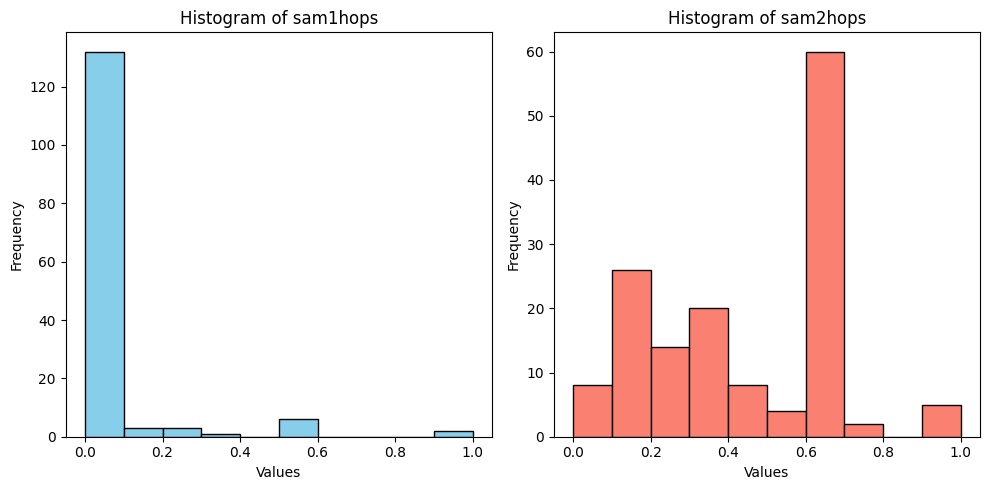

In [18]:
# 绘制直方图
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(sam1hops, bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of sam1hops')

plt.subplot(1, 2, 2)
plt.hist(sam2hops, bins=10, color='salmon', edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of sam2hops')

plt.tight_layout()
plt.show()

In [19]:
# 逃逸攻击
test_acc = evaluate_test(best_model, adj, adj_2hop)
print("test acc: {:.4f}".format(test_acc))

test acc: 0.5918
